# Autoencoder for MNIST

Welcome to this notebook where you'll be training an autoencoder using the MNIST dataset, which comprises handwritten digits. This exercise is the last where we present you with a structured skeleton to work with. However, in following exercises, we will only provide you with the dataset, task, and a test scenario, enabling you to test your skills and compete with your peers on our leaderboards. Get ready to dive in and showcase your deep learning expertise!


## Your task:

Autoencoders have various applications, including unsupervised pretraining using unlabeled data, followed by fine-tuning the encoder with labeled data. This approach can greatly enhance performance when there is only a little amount of labeled data but a lot of unlabeled data available.

In this exercise, you will use the MNIST dataset, consisting of 60,000 images of handwritten digits. However, not all the image labels are available to you. Your first objective is to train an autoencoder to accurately reproduce these unlabeled images.

Afterwards, you will transfer the weights of the pretrained encoder and perform fine-tuning on a classifier using the available labeled data. This technique is commonly known as **transfer learning**, which allows you to leverage the knowledge gained from the autoencoder to improve the classification of the handwritten digits.

In [84]:
# For automatic file reloading as usual
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [85]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_08) is given.

# from google.colab import drive
# import os

"""
from google.colab import drive
import os
gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_08'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
"""

"\nfrom google.colab import drive\nimport os\ngdrive_path='/content/gdrive/MyDrive/i2dl/exercise_08'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\n"

### Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU
- Uncomment the following cell if you are using the notebook in google colab:

In [86]:
# Optional: install correct libraries in google colab
# !python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchtext==0.12.0+cu113 torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !python -m pip install tensorboard==2.8.0 > /dev/null
# !python -m pip install pytorch-lightning==1.6.0

# Imports

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, sys
import shutil
import torch
import torch.nn as nn
from torchvision import transforms
from exercise_code.image_folder_dataset import ImageFolderDataset
from torch.utils.tensorboard import SummaryWriter
from time import sleep
from tqdm import tqdm
from exercise_code.tests.base_tests import bcolors

torch.manual_seed(42)

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

<div class="alert alert-warning">
    <h3>Note: Google Colab</h3>
    <p>
In case you don't have a GPU, you can run this notebook on Google Colab where you can access a GPU for free, but, of course, you can also run this notebook on your CPU.
         </p>
</div>

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('You are using the following device: ', device)

You are using the following device:  cpu


## Setup TensorBoard

In the previous exercise (Exercise 07), you learned how to use TensorBoard effectively. Let's use it again to enhance the convenience of debugging your network and the training process. Throughout this notebook, feel free to implement additional logs or visualizations into your TensorBoard, further improving your analysis and understanding of the network's behavior. 

In [89]:
################# COLAB ONLY #################
# %load_ext tensorboard
# %tensorboard --logdir=./ --port 6006

# Use the cmd for less trouble, if you can. From the working directory, run: tensorboard --logdir=./ --port 6006

# 1. The MNIST Dataset

First, let's download the MNIST dataset. As mentioned in the beginning of this notebook, MNIST is a dataset of 60,000 images depicting handwritten digits. However, labeling such a large dataset can be a costly process, leaving us in a challenging situation.

To overcome this, a practical approach is to label a small subset of the images. Let's consider a scenario where you have hired another student to perform the labeling task for you. After some time, you have been provided with 300 labeled images. Out of these, 100 images will be used for training, another 100 for validation, and the remaining 100 for testing. Undoubtedly, this poses a challenge due to the limited number of labeled samples.

Now, you have the flexibility to define any transforms that you deem necessary, either at this point or at a later stage. However, it's important to note that during the final evaluation on the server, no transformations will be applied to the test set.

Feel free to experiment with various transforms as you proceed (you can also pass without any transforms). 


**Note**: We do **not** apply any transformations to the test set at the time of final evaluation on our server.

In [90]:
import torchvision.transforms as transforms

transform = transforms.Compose([])

########################################################################
# TODO: Feel free to define transforms                                 #
########################################################################

# MNIST mean: 0.1307, std: 0.3081

transform = transforms.Compose([
    # transforms.Normalize((0.1307), (0.3081)), # Apparently normalizing results in terrible submission results
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
    transforms.RandomApply(torch.nn.ModuleList([
     transforms.RandomRotation(degrees=30)]), p=0.4)
    
    ])

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
mnist_root = os.path.join(i2dl_exercises_path, "datasets", "mnist")

train_100_dataset = ImageFolderDataset(root=mnist_root,images='train_images.pt',labels='train_labels.pt',force_download=False,verbose=True,transform=transform)
val_100_dataset = ImageFolderDataset(root=mnist_root,images='val_images.pt',labels='val_labels.pt',force_download=False,verbose=True,transform=transform)
test_100_dataset = ImageFolderDataset(root=mnist_root,images='test_images.pt',labels='test_labels.pt',force_download=False,verbose=True,transform=transform)

# We also set up the unlabeled images which we will use later
unlabeled_train = ImageFolderDataset(root=mnist_root,images='unlabeled_train_images.pt',force_download=False,verbose=True,transform=transform)
unlabeled_val = ImageFolderDataset(root=mnist_root,images='unlabeled_val_images.pt',force_download=False,verbose=True,transform=transform)



Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip


The dataset consists of tuples of 28x28 pixel PIL images and a label that is an integer from 0 to 9. 

Let's turn a few of the images into numpy arrays, to look at their shape and visualize them and see if the labels we paid for are correct.

The shape of our greyscale images:  (28, 28)


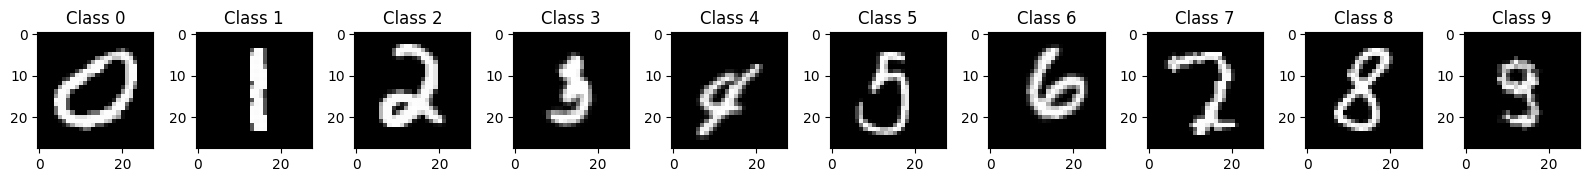

In [91]:
plt.rcParams['figure.figsize'] = (16,16) # Make the figures a bit bigger

indices_arr = [83, 98, 92, 99, 78, 97, 90, 95, 93, 96]
for i, index in enumerate(indices_arr):
    image = np.array(train_100_dataset[index][0].squeeze()) # get the image of the data sample
    label = train_100_dataset[index][1] # get the label of the data sample
    plt.subplot(1, 10, i + 1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Class {}".format(label))
    
plt.tight_layout()
print('The shape of our greyscale images: ', image.shape)

<div class="alert alert-warning">
    <h3>Note: Starting Simple</h3>
    <p>
Regardless of the size of the dataset, the first step is to evaluate the performance of a simple classifier. It is advisable to always start with a straightforward approach when tackling a problem and gradually build upon it to determine which changes yield improvements.</p>
</div>

# 2. A Simple Classifier

In `exercise_code/models.py` we prepared all classes for you which you will finalize throughout the notebook to build an Autoencoder and an image classifier with PyTorch.

![network_split](img/network_split.png)

## 2.1 The Encoder

Unlike to previous models, we are going to split up the model into two parts: the `encoder` and the `classifier`. The `classifier` has a fixed task, generating predictions given a one-dimensional input. On the other hand, the `encoder`'s task is to extract meaningful information from the input, enabling the classifier to make accurate decisions. 

For now, both networks will be similar in design and consist of linear layers coupled with auxiliary layers. This split-up will be relevant later, e.g., by using convolutional layers which are introduced in the lecture. We are going to set up the `encoder` now. 

Think about a good network architecture. You have complete freedom in this regard and can devise any network structure that you think might be fitting. (\*)

Have a look at the documentation of `torch.nn` at https://pytorch.org/docs/stable/nn.html to learn how to use this module in order to build your network!

Then implement your architecture: initialize it in `__init__()` and assign it to `self.model`. This is particularly easy using `nn.Sequential()` where you only have to pass the list of your layers. 

To make your model customizable and support parameter search, do not use hardcoded hyperparameters - instead, pass them as a simple dictionary `hparams` (here, `n_hidden` is the number of neurons in the hidden layer) when initializing `models`.

Here is an simple example:

```python
        self.model = nn.Sequential(
            nn.Linear(input_size, self.hparams["n_hidden"]),
            nn.ReLU(),            
            nn.Linear(self.hparams["n_hidden"], num_classes)
        )
```

Have a look at the forward path in `forward(self, x)`, which is so easy that you don't need to implement it yourself.

As PyTorch automatically computes the gradients, that's all you need to do! No need to manually calculate derivatives for the backward paths anymore! :)


____
\* *The size of your final model must be less than 20 MB, which is approximately equivalent to 5 Mio. params. Note that this limit is quite lenient, you will probably need much less parameters!*

*In order to keep things simple, you should only use fully connected layers for this task as we need to revert the encoder architecture  later on in the notebook.*

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Encoder</code> class initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

## 2.2 The Classifier

Now let's implement the classifier. The classifier will utilize the encoder that you have defined in the above cell. By looking at `Classifier.forward`, you can see that we are essentially concatenating the `classifier`and the `encoder` together. Therefore, it is crucial to ensure that the input shape of the classifier matches the output shape of the encoder you implemented above

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>1. Implement the <code>Classifier</code> class network initialization in <code>exercise_code/models.py</code>.
    </p>
    <p>2. Define in the next cell your hyperparameters in a dictionary called 'hparams'.
    </p>
</div>

In [92]:
hparams = {}
########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################

# This is just used for testing the classifier I think, not used for the submission. So keep it reasonable

hparams = {    
    "device" : device,
    "num_workers" : 8,
    "epochs" : 200,
    "batch_size" : 4096,
    
    "num_classes" : 10, # There are 10 digits
    "input_size" : 28 * 28, # Number of pixels in images
    
    "learning_rate" : 2e-3, # Optimizer
    "weight_decay" : 1e-5, # ADAM
    
    "dropout_p" : 0.5, # Dropout probability for the classifier, reduces overfitting
    "latent_dim" : 20, # Encoder output dim, Decode input dim, classifier input dim. If this it too high, overfitting will occur
    # "decoder_hidden" : 50, # Decoder Hidden
    "encoder_hidden" : 512, # Encoder Hidden
    "classifier_hidden" : 2048 # Classifier Hidden
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################


## 2.3 Optimizer
Lastly, implement the function `set_optimizer` to define your optimizer. Here the documentation of `torch.optim` at https://pytorch.org/docs/stable/optim.html might be helpful.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>set_optimizer</code> method of the <code>Classifier</code> in <code>exercise_code/models.py</code>.
    </p>
</div>


## 2.4 Training & Validation Step

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p> Let's take a closer look at the training pipeline outlined below. It is explicitly written here in its entirety to provide you with a comprehensive understanding of its structure. Additionally, you can refer back to this pipeline whenever you encounter any uncertainties or need guidance.
 </p>
</div>


In [93]:
 # One of the most crucial things in deep learning is to understand the training pipeline:
 # 1. Forward()          --> The forward pass of the network, to calculate the currnent loss.
 # 2. Backward()         --> The backward pass of the network, to calculate the gradients w.r.t the loss, calculated in the previous stage.
 # 3. Optimizer_step()   --> Update the weights w.r.t thier corresponding gradients and the learnign rate.

def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=150, desc=desc)


def train_classifier(classifier, train_loader, val_loader, loss_func, tb_logger, epochs=10, name="default"):
    """
    Train the classifier for a number of epochs.
    """
    optimizer = classifier.optimizer
    classifier = classifier.to(device)
    for epoch in range(epochs):
        
        training_loss = 0
        validation_loss = 0
        
        # Training stage, where we want to update the parameters.
        classifier.train()  # Set the model to training mode
        
        # Create a progress bar for the training loop.
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]')
        for train_iteration, batch in training_loop:
            optimizer.zero_grad() # Reset the gradients - VERY important! Otherwise they accumulate.
            images, labels = batch # Get the images and labels from the batch, in the fashion we defined in the dataset and dataloader.
            images, labels = images.to(device), labels.to(device) # Send the data to the device (GPU or CPU) - it has to be the same device as the model.

            # Flatten the images to a vector. This is done because the classifier expects a vector as input.
            # Could also be done by reshaping the images in the dataset.
            images = images.view(images.shape[0], -1) 

            pred = classifier(images) # Stage 1: Forward().
            loss = loss_func(pred, labels) # Compute the loss over the predictions and the ground truth.
            loss.backward()  # Stage 2: Backward().
            optimizer.step() # Stage 3: Update the parameters.

            training_loss += loss.item()

            # Update the progress bar.
            training_loop.set_postfix(curr_train_loss = "{:.8f}".format(training_loss / (train_iteration + 1)), val_loss = "{:.8f}".format(validation_loss))

            # Update the tensorboard logger.
            tb_logger.add_scalar(f'classifier_{name}/train_loss', loss.item(), epoch * len(train_loader) + train_iteration)
            sleep(0.1) # Remove this line if you want to see the progress bar faster.

        # Validation stage, where we don't want to update the parameters. Pay attention to the classifier.eval() line
        # and "with torch.no_grad()" wrapper.
        classifier.eval()
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch + 1}/{epochs}]')
        validation_loss = 0
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                images = images.view(images.shape[0], -1) 
                pred = classifier(images)
                loss = loss_func(pred, labels)
                validation_loss += loss.item()

                # Update the progress bar.
                val_loop.set_postfix(val_loss = "{:.8f}".format(validation_loss / (val_iteration + 1)))

                # Update the tensorboard logger.
                tb_logger.add_scalar(f'classifier_{name}/val_loss', loss.item(), epoch * len(val_loader) + val_iteration)
                sleep(0.1) # Remove this line if you want to see the progress bar faster.
        
        # This value is used for the progress bar of the training loop.
        validation_loss /= len(val_loader)
            

## 2.5 Fit Classification Model with Trainer
Now it's finally time to train your model.
Run the following cell to see the behold the magic of deep learning at play.

In [94]:
from exercise_code.models import Classifier
from exercise_code.models import Encoder

# Create the encoder and the classifier.
encoder = Encoder(hparams).to(device)
classifier = Classifier(hparams, encoder).to(device)

# Create a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.

path = os.path.join('logs', 'cls_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')

tb_logger = SummaryWriter(path)

# Train the classifier.
labled_train_loader = torch.utils.data.DataLoader(train_100_dataset, batch_size=hparams['batch_size'], shuffle=True)
labled_val_loader = torch.utils.data.DataLoader(val_100_dataset, batch_size=hparams['batch_size'], shuffle=False)

epochs = hparams.get('epochs', 10)
loss_func = nn.CrossEntropyLoss() # The loss function we use for classification.
train_classifier(classifier, labled_train_loader, labled_val_loader, loss_func, tb_logger, epochs=epochs, name="Default")

print("Finished training!")
print("How did we do? Let's check the accuracy of the defaut classifier on the training and validation sets:")
print(f"Training Acc: {classifier.getAcc(labled_train_loader)[1] * 100}%")
print(f"Validation Acc: {classifier.getAcc(labled_val_loader)[1] * 100}%")

Validation Epoch [200/200]: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.63it/s, val_loss=1.34518051]


Finished training!
How did we do? Let's check the accuracy of the defaut classifier on the training and validation sets:
Training Acc: 92.0%
Validation Acc: 61.0%


# 3. Autoencoder

With only a limited number of labeled images, it's challenging to achieve high performance. We have no money left to pay the student to create more labels, and labeling the data ourselves is out of question. A commonly used approach would be to apply data augmentation to maximize the potential of our limited labeled data, but here we provide another way to solve this problem: **transfer learning**.

For each input, the autoencoder tries to reproduce the same image as an output. The difficulty behind this task is that the autoencoder has to go through a low dimensional bottleneck, which is called the **latent space**.
In other words, the autoencoder learns to represent all the input information in a low dimensional latent space - it learns to compress the input distribution. To train the autoencoder, we use the mean squared error loss, which calculates the discrepancy between the input pixels and the output pixels. The best part is that this loss function doesn't require any labels!

By pretraining the autoencoder in this way on the large amount of unlabeled data, we can capture valuable latent representations of the input images. Then, we transfer the weights of the encoder to our classifier, enabling it to benefit from the knowledge learned during the unsupervised pretraining phase. 

![autoencoder](img/autoencoder.png)

After this, our encoder has learned to extract meaningful information from the inputs. We can then transfer its weights
to a classifier architecture and finetune it with our labeled data, i.e., instead of initializing our encoder randomly we are re-using the weights of our trained encoder from our autoencoder network. 

![autoencoder_pretrained](img/pretrained.png)

## 3.1 Decoder

Before we can train our autoencoder, you have to initialize the your `decoder` architecture. The simplest way is to mirror your encoder architecture which ensure that the `latent space` output of our `encoder` is correctly transformed to our input shape.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Decoder</code> and <code>Autoencoder</code> class initialization in <code>exercise_code/models.py</code>.</p>
    <p>Implemet <code>training_step</code> and <code>validation_step</code> of the autoencoder, following the pipeline we've shown you in train_classifier().</p>
    <p>Note the differences between the classificaiton task, and now the regression task!</p>


</div>

## 3.2 Autoencoder Training

Now, we can train the full autoencoder consisting of both en- and decoder.

In [95]:
from exercise_code.models import Autoencoder, Encoder, Decoder

########################################################################
# TODO: Define your hyperparameters here!                              #
# Hint: use a large batch_size                                         #
########################################################################

hparams = {    
    "device" : device,
    "num_workers" : 8,
    "epochs" : 100,
    "batch_size" : 2048,
    
    "num_classes" : 10, # There are 10 digits
    "input_size" : 28 * 28, # Number of pixels in images
    
    "learning_rate" : 2e-3, # Optimizer
    "weight_decay" : 1e-5, # ADAM
    
    "dropout_p" : 0.5, # Dropout probability for the classifier, reduces overfitting
    "latent_dim" : 20, # Encoder output dim, Decode input dim, classifier input dim. If this it too high, overfitting will occur
    "decoder_hidden" : 512, # Decoder Hidden
    "encoder_hidden" : 512, # Encoder Hidden
    # "classifier_hidden" : 2048 # Classifier Hidden
}


########################################################################
#                           END OF YOUR CODE                           #
########################################################################
encoder_pretrained = Encoder(hparams).to(device)
decoder = Decoder(hparams).to(device)
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder).to(device)

Some tests to check whether we'll accept your model.

In [96]:
from exercise_code.Util import printModelInfo, load_model
_ = printModelInfo(autoencoder)

# Paramters: Your model has 1.078 mio. params.
Model accepted!


After implementing the relevant functions - read the following code, and then run it.
Keep in mind that an epoch here will take much longer since
we are iterating through 5,8600 images instead of just 100.

For speed, colab is indeed recommended. 

In [97]:
encoder_pretrained = Encoder(hparams).to(device)
decoder = Decoder(hparams).to(device)
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder).to(device)

def train_model(model, train_loader, val_loader, loss_func, tb_logger, epochs=10, name='Autoencoder'):
    
    optimizer = model.optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs * len(train_loader) / 5, gamma=0.7)
    validation_loss = 0
    model = model.to(device)
    for epoch in range(epochs):
        
        # Train
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch}/{epochs}]')
        training_loss = 0
        for train_iteration, batch in training_loop:
            
            loss = model.training_step(batch, loss_func) # You need to implement this function.
            training_loss += loss.item()
            scheduler.step()

            # Update the progress bar.
            training_loop.set_postfix(train_loss = "{:.8f}".format(training_loss / (train_iteration + 1)), val_loss = "{:.8f}".format(validation_loss))

            # Update the tensorboard logger.
            tb_logger.add_scalar(f'{name}/train_loss', loss.item(), epoch * len(train_loader) + train_iteration)

        # Validation
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch}/{epochs}]')
        validation_loss = 0
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                loss = model.validation_step(batch, loss_func) # You need to implement this function.
                validation_loss += loss.item()

                # Update the progress bar.
                val_loop.set_postfix(val_loss = "{:.8f}".format(validation_loss / (val_iteration + 1)))

                # Update the tensorboard logger.
                tb_logger.add_scalar(f'{name}/val_loss', validation_loss / (val_iteration + 1), epoch * len(val_loader) + val_iteration)
        # This value is for the progress bar of the training loop.
        validation_loss /= len(val_loader)

# Creat a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.

path = os.path.join('logs', 'ae_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')
tb_logger = SummaryWriter(path)

# Train the classifier.
unlabled_train_loader = torch.utils.data.DataLoader(unlabeled_train, batch_size=hparams['batch_size'], shuffle=True)
unlabled_val_loader = torch.utils.data.DataLoader(unlabeled_val, batch_size=hparams['batch_size'], shuffle=False)

epochs = hparams.get('epochs', 5)
loss_func = nn.MSELoss() # The loss function we use for regression (Could also be nn.L1Loss()).
train_model(autoencoder, unlabled_train_loader, unlabled_val_loader, loss_func, tb_logger, epochs=epochs, name='Autoencoder')

print("Finished training!")

Validation Epoch [99/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s, val_loss=0.04187918]

Finished training!


Once trained, let's have a look at the reconstructed validation images (If you have not already looked at them in TensorBoard).

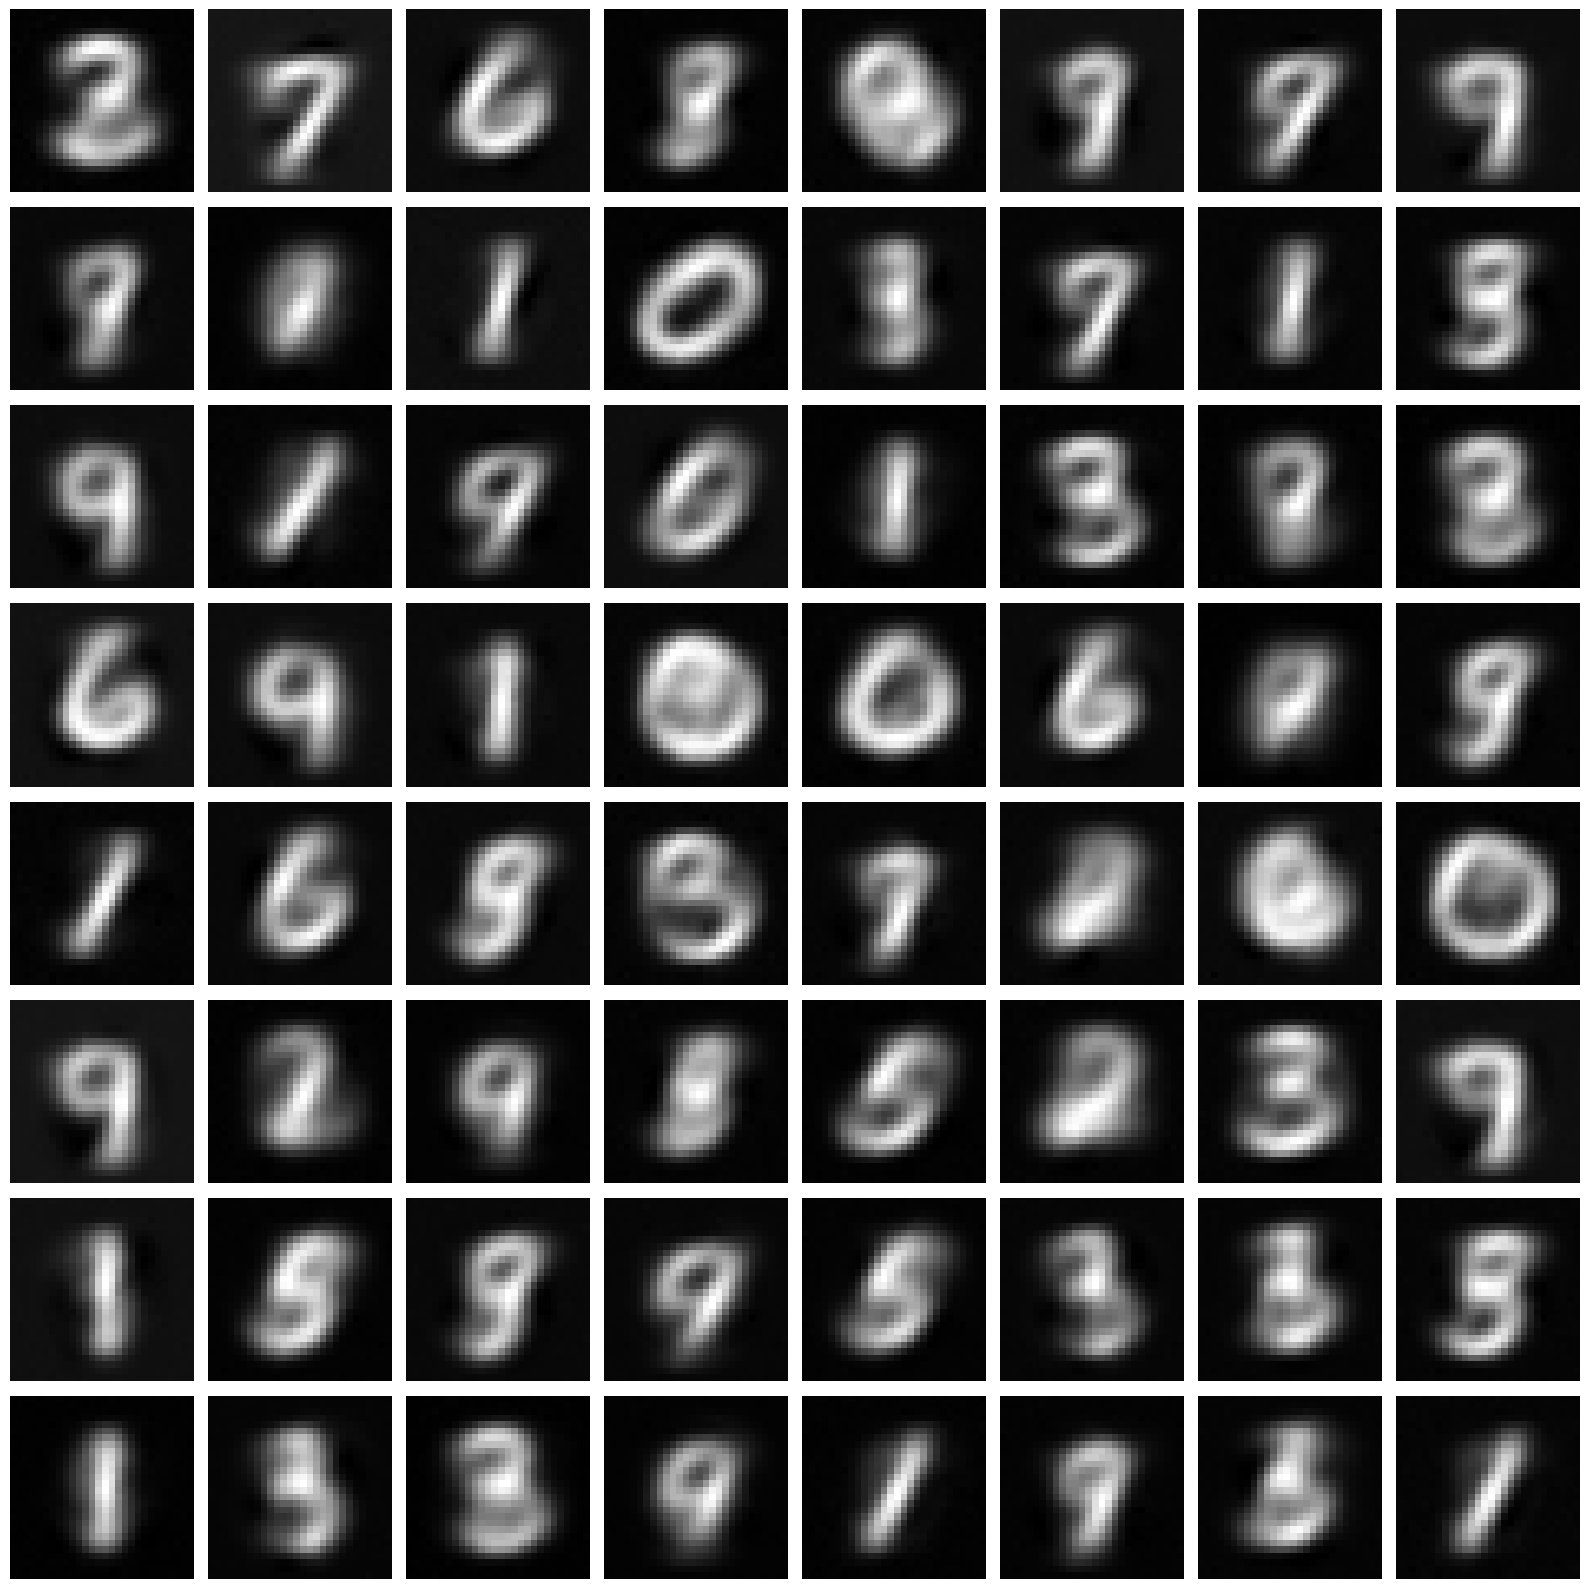

In [98]:
reconstructions = autoencoder.getReconstructions(unlabled_val_loader)
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.imshow(reconstructions[i], cmap='gray', interpolation='none')
    
plt.tight_layout()

# 4. Transfer Learning

## 4.1 The pretrained Classifier

Now we initialize another classifier but this time with the pretrained encoder.

In [99]:
from exercise_code.models import Classifier
from copy import deepcopy

hparams = {}
########################################################################
# TODO: Define your hyperparameters here!                             #
########################################################################

hparams = {    
    "device" : device,
    "num_workers" : 8,
    "epochs" : 800,
    "batch_size" : 2048,
    
    "num_classes" : 10, # There are 10 digits
    "input_size" : 28 * 28, # Number of pixels in images
    
    "learning_rate" : 2e-3, # Optimizer
    "weight_decay" : 1e-5, # ADAM
    
    "dropout_p" : 0.5, # Dropout probability for the classifier, reduces overfitting
    "latent_dim" : 20, # Encoder output dim, Decode input dim, classifier input dim. If this it too high, overfitting will occur
    "decoder_hidden" : 512, # Decoder Hidden
    "encoder_hidden" : 512, # Encoder Hidden
    "classifier_hidden" : 2048 # Classifier Hidden
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

encoder_pretrained_copy = deepcopy(encoder_pretrained)
classifier_pretrained = Classifier(hparams, encoder_pretrained_copy).to(device)

Let's define another trainer that will utilize the pretrained classifier, allowing us to compare its performance with the classifier trained only on the labeled data. To achieve a reasonable result, you may need to optimize the parameters you defined earlier.

In [100]:

# Creat a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.
# Pay attention that if you run this cell mutltiple times, the pretrained_encoder
# is not reset, and will keep training from where it stopped. Thus, it could overfit.

path = os.path.join('logs', 'pretrained_cls_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')
tb_logger = SummaryWriter(path)

batch_size = hparams.get('batch_size', 16)
labled_train_loader = torch.utils.data.DataLoader(train_100_dataset, batch_size=batch_size, shuffle=True)
labled_val_loader = torch.utils.data.DataLoader(val_100_dataset, batch_size=batch_size, shuffle=False)

epochs = hparams.get('epochs', 20)
loss_func = nn.CrossEntropyLoss() # The loss function we use for classification.
train_classifier(classifier_pretrained, labled_train_loader, labled_val_loader, loss_func, tb_logger, epochs=epochs, name='Pretrained')

print("Finished training!") 

Validation Epoch [800/800]: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.65it/s, val_loss=1.13346767]

Finished training!


Let's have a look at the validation accuracy of the two different classifiers and compare them. And don't forget that you can also monitor your training in TensorBoard.

We will only look at the test accuracy and compare our two classifiers with respect to that in the very end.

In [101]:
val_acc_scracth = classifier.getAcc(labled_val_loader)[1]*100
color = 'green' if val_acc_scracth > 55 else 'red'
print(f"Validation accuracy when training from scratch: {bcolors.colorize(color, val_acc_scracth)}%")

val_acc_pretrained = classifier_pretrained.getAcc(labled_val_loader)[1]*100
color = 'green' if val_acc_pretrained > 55 else 'red'
print(f"Validation accuracy with pretraining: {bcolors.colorize(color, val_acc_pretrained)}%")




Validation accuracy when training from scratch: 64.0%
Validation accuracy with pretraining: 73.0%


Now that everything is working, feel free to play around with different architectures. As you've seen, it's quite easy to define your model or do adpations there.

To pass this submission, you will need to achieve an accuracy of **55%**.

# Save your model & Report Test Accuracy

When you are finally done with your **hyperparameter tuning**, achieved **at least 55% validation accuracy** and are happy with your final model, you can save it here.

Before that, please check again whether the number of parameters is below 5 Mio and the file size is below 20 MB.

Once your final model is saved, we'll finally report the test accuracy.

In [102]:
from exercise_code.Util import test_and_save
test_dl = torch.utils.data.DataLoader(test_100_dataset, batch_size=4, shuffle=False)

test_acc = classifier.getAcc(test_dl)[1]*100
color = 'green' if test_acc > 55 else 'red'
print(f"Test accuracy when training from scratch: {bcolors.colorize(color, test_acc)}%")

test_acc = classifier_pretrained.getAcc(test_dl)[1]*100
color = 'green' if test_acc > 55 else 'red'
print(f"Test accuracy with pretraining: {bcolors.colorize(color, test_acc)}%")

test_and_save(classifier_pretrained, labled_val_loader, test_dl)

Test accuracy when training from scratch: 65.0%
Test accuracy with pretraining: 88.0%
Validation Accuracy: 70.0%
# Paramters: Your model has 0.602 mio. params.
Size: Great! Your model size is 4.6 MB and is less than 20 MB.
Your model has been saved and is ready to be submitted.


In [103]:
# Now zip the folder for upload
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise_08')

relevant folders: ['exercise_code', 'models']
notebooks files: ['Optional-BatchNormalization_Dropout.ipynb', '1_Autoencoder.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook Optional-BatchNormalization_Dropout.ipynb
Adding notebook 1_Autoencoder.ipynb
Zipping successful! Zip is stored under: /home/timm_pop/Documents/i2dl/output/exercise_08.zip


Congratulations on completing your first autoencoder and successfully transferring the weights to a classifier! It's remarkable how much easier this process becomes with the power of PyTorch, compared to working with plain NumPy, right?

To complete the exercise, please submit your final model to [our submission portal](https://i2dl.vc.in.tum.de/) - you should be already familiar with the submission procedure. Next, it is time to get started with some more complex neural networks and tasks in the upcoming exercises. See you next week!

# Submission Goals

- Goal: Successfully implement a fully connected autoencoder for MNIST with Pytorch and transfer the encoder weights to a classifier.

- Passing Criteria: There are no unit tests that check specific components of your code. The only thing that's required to pass the submission, is your model to reach at least **55% accuracy** on __our__ test dataset. The submission system will show you a number between 0 and 100 which corresponds to your accuracy.

- Submission start: __June 15, 2023 10:00__
- Submission deadline : __June 21, 2023 15:59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for the bonus.

# [Exercise Review](https://forms.gle/9SYivCPQZdktRDS29)

We are always interested in your opinion. Now that you have finished this exercise, we would like you to give us some feedback about the time required to finish the submission and/or work through the notebooks. Please take the short time to fill out our [review form](https://forms.gle/9SYivCPQZdktRDS29) for this exercise so that we can do better next time! :)